### Hypothesis Testing

pooled, unpooled, assuming the control to be correct
https://stats.stackexchange.com/questions/354556/what-is-the-standard-error-for-hypothesis-testing-of-two-proportions-using-a-z-t?rq=1

In [269]:
import re

import numpy as np
import scipy.stats as scs

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import seaborn as sns

pd.set_option('display.max_columns', 30)
sns.set_style('white')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact

from statsmodels.stats.proportion import proportions_ztest

### Binomial Random Variables

In [95]:
def generate_binomial_data(n_A, n_B, p_A, p_B):
    
    """
    Returns a pandas dataframe with random variables 
    following a binomial distribution.
    
    Parameters:
    n_A (int): Sample size for control group
    n_B (int): Sample size for experiment group
    p_A (float): Conversion rate of control group
    p_B (float): Conversion rate of experiment group
    
    Returns: 
    df
    
    """
    
    generated_values_A = scs.bernoulli(p_A).rvs(n_A)
    generated_values_B = scs.bernoulli(p_B).rvs(n_B)
    
    df = pd.DataFrame({
        'A': generated_values_A,
        'B': generated_values_B
    }).melt().rename(columns={'variable': 'group', 
                              'value': 'converted'})
         
    
    return df

ab_data = generate_binomial_data(100, 100, 0.5, 0.4)
ab_data.head()

,group,converted
0,A,0
1,A,1
2,A,0
3,A,0
4,A,0


In [96]:
# contingency table
def contingency_table(df):
    
    pivot = pd.pivot_table(df, 
                           index='group', 
                           aggfunc = {'converted': [np.sum,
                                                    lambda x: len(x),
                                                    np.mean]})
    
    # dropping redundant level 'converted'
    pivot.columns = pivot.columns.droplevel(0)
    
    # rename columns
    pivot.rename(columns={'<lambda>': 'total',
                          'mean': 'rate', 
                          'sum': 'converted'}, inplace=True)
    
    
    return pivot[['converted', 'total', 'rate']]

contingency_table(ab_data)

,converted,total,rate
group,,,
A,50.0,100.0,0.50
B,36.0,100.0,0.36


What is a Binomial Random Variable?
- There can only be 2 outcomes for each trial
- Probability of success has to be the same for each trial
- Fixed number of trials

X ~ B(n, p)

E(X) = np <br>
The mean of Binomial RV X = np

Var(X) = p(1-p) <br>
The variance of Binomial RV X = p(1-p)

In [90]:
def manual_binomial_stats(n, p):
    """
    Returns the mean and variance of a Binomial Random Variable
    
    Parameters:
    n (int): number of trials
    p (float): probability of success for each trial
    
    Output: 
    tuple: (mean, variance)
    """
    
    mean = n * p
    variance = p * (1-p)
    
    return (mean, variance)

In [97]:
manual_binomial_stats(100, 0.5)

(50.0, 0.25)

In [98]:
scs.binom(100, 0.5).stats()

(array(50.), array(25.))

In [99]:
print('Variance of Array: ', 
      np.var(ab_data[ab_data['group']=='A']['converted']))

Variance of Array:  0.25


In [108]:
def plot_binomial_distribution(n, p):
    
    fig, ax = plt.subplots(figsize=(12,6))
    x = np.linspace(start=0, stop=n, num=n+1)
    y = scs.binom(n, p).pmf(x)
    
    plt.xlabel('# of Successes')
    plt.ylabel('Probability Distribution Function (PDF)')

    return ax.bar(x, y)

In [112]:
interact(plot_binomial_distribution, n=(0, 100), p=(0, 1, 0.1));

interactive(children=(IntSlider(value=50, description='n'), FloatSlider(value=0.0, description='p', max=1.0), …

In [368]:
class ABTest:
    
    def __init__(self, df=None, 
                 n_A=None, converted_A=None, 
                 n_B=None, converted_B=None):
        
        if (df is None) & (n_A is None 
                           and converted_A is None 
                           and n_B is None 
                           and converted_B is None):
            raise Exception('Input either a df or parameters for n_A, converted_A, n_B and converted_B')
            
        elif (df is None) & (n_A is None 
                             or converted_A is None 
                             or n_B is None 
                             or converted_B is None):
            raise Exception('Input all fields for n_A, converted_A, n_B, converted_B')
        
        elif df is not None:
            self.raw_data = df
            self.group_label = input('Group Label')
            self.group_names = re.sub('(?<=,)[\s]', '', input('Group Names in Array')).split(',')
            self.result_label = input('Result Label')
            
            self.n_A = len(df[df[self.group_label]==self.group_names[0]])
            self.converted_A = len(df[(df[self.group_label]==self.group_names[0]) & 
                                      (df[self.result_label]==1)])
            self.p_A = self.converted_A / self.n_A
            
            self.n_B = len(df[df[self.group_label]==self.group_names[1]])
            self.converted_B = len(df[(df[self.group_label]==self.group_names[1]) & 
                                      (df[self.result_label]==1)])
            self.p_B = self.converted_B / self.n_B
            
        elif df is None:
            
            self.n_A = n_A
            self.converted_A = converted_A
            self.p_A = converted_A / n_A
            
            self.n_B = n_B
            self.converted_B = converted_B
            self.p_B = converted_B / n_B
            
    def contingency_table(self):
        pivot = pd.pivot_table(self.raw_data, 
                               index=self.group_label, 
                               aggfunc = {self.result_label: [np.sum,
                                                              lambda x: len(x),
                                                              np.mean]})

        # dropping redundant level 'converted'
        pivot.columns = pivot.columns.droplevel(0)

        # rename columns
        pivot.rename(columns={'<lambda>': 'total',
                              'mean': 'rate', 
                              'sum': 'converted'}, inplace=True)


        return pivot[['converted', 'total', 'rate']]
    
    def plot_binomial_distribution(self):
        
        fig, ax = plt.subplots(figsize=(12,6))
        
        x_A = np.linspace(start=0, stop=self.n_A, num=self.n_A+1)
        y_A = scs.binom(self.n_A, self.p_A).pmf(x_A)

        x_B = np.linspace(start=0, stop=self.n_B, num=self.n_B+1)
        y_B = scs.binom(self.n_B, self.p_B).pmf(x_B)

        ax.bar(x_A, y_A, alpha=0.5, label='control/null', color='cornflowerblue')
        ax.bar(x_B, y_B, alpha=0.5, label='experiment/alternate', color='lightcoral')

        plt.xlabel('# of Successes')
        plt.ylabel('Probability Mass Function (PMF)')
        plt.legend();
    
    def plot_sampling_dist(self):
        
        SE_A = np.sqrt(self.p_A * (1 - self.p_A) / n_A)
        SE_B = np.sqrt(self.p_B * (1 - self.p_B) / n_B)
        
        fig, ax = plt.subplots(figsize=(12,6))
        
        x = np.linspace(0, 1, 100)
        
        y_A = scs.norm(self.p_A, SE_A).pdf(x)
        ax.plot(x, y_A, label='control/null', c='cornflowerblue')
        ax.axvline(x=self.p_A, linestyle='--', c='cornflowerblue')
        
        y_B = scs.norm(self.p_B, SE_B).pdf(x)
        ax.plot(x, y_B, label='experiment/alternate', c='lightcoral')
        ax.axvline(x=self.p_B, linestyle='--', c='lightcoral')
        
        plt.xlabel('Sample Proportion')
        plt.ylabel('Probability Density Function (PDF)')
        plt.legend();
        

    def plot_sampling_dist_of_difference(self):
        
        delta = self.p_B - self.p_A
        pooled_proportion = (self.converted_A + self.converted_B) / (self.n_A + self.n_B)
        std_error_pooled = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/self.n_A + 1/self.n_B))
        
        fig, ax = plt.subplots(figsize=(12,6))
        
        x = np.linspace(-1, 1, 100)
        
        y_null = scs.norm(0, std_error_pooled).pdf(x)   # 0 because null hypothesis is no difference
        ax.plot(x, y_null, label='control/null', c='cornflowerblue')
        ax.axvline(x=0, linestyle='--', c='lightgrey')
        
        y_alt = scs.norm(delta, std_error_pooled).pdf(x)
        ax.plot(x, y_alt, label='experiment/alternate', c='lightcoral')
        ax.axvline(x=delta, linestyle='--', c='lightcoral')
        
        plt.xlabel('Difference in Sample Proportions')
        plt.ylabel('Probability Density FUnction (PDF)')
        plt.legend();
        
    def plot_sampling_dist_of_difference_standardized(self, sig_level, alternative):
        
        delta = self.p_B - self.p_A
        pooled_proportion = (self.converted_A + self.converted_B) / (self.n_A + self.n_B)
        std_error_pooled = np.sqrt(pooled_proportion * (1 - pooled_proportion) * (1/self.n_A + 1/self.n_B))
        
        Z_value = (delta - 0) / std_error_pooled
        
        if alternative == 'smaller':
            critical_value = scs.norm(0, 1).ppf(sig_level)
        elif alternative == 'larger':
            critical_value = scs.norm(0, 1).ppf(1 - sig_level)
        elif alternative == 'two-tailed':
            critical_value = [scs.norm(0, 1).ppf(sig_level / 2), scs.norm(0, 1).ppf(1 - (sig_level / 2))]
        
        fig, ax = plt.subplots(figsize=(12,6))
        
        x = np.linspace(-4, 4, 100)
        
        y_null = scs.norm(0, 1).pdf(x)
        ax.plot(x, y_null, label='control/null', c='cornflowerblue')
        ax.axvline(x=Z_value, linestyle='--', c='cornflowerblue')
        
        if alternative == 'two-tailed':
            ax.axvline(x=critical_value[0], linestyle = '--', c='black')
            ax.axvline(x=critical_value[1], linestyle = '--', c='black')
        else: 
            ax.axvline(x=critical_value, linestyle = '--', c='black')
        
        y_alt = scs.norm(Z_value, 1).pdf(x)
        ax.plot(x, y_alt, label='experiment/alternate', c='lightcoral', linestyle='--')
        
        plt.xlabel('Z-value, relative to the NULL hypothesis')
        plt.ylabel('Probability Density Function (PDF)')
        plt.legend();

        
        
        

# calculate z score, pvalue and confidence intervals


        
dummydata = ABTest(ab_data)
# dummydata = ABTest(n_A=100, converted_A=35, n_B=120, converted_B=42)
    
    

Group Labelgroup
Group Names in ArrayA, B
Result Labelconverted


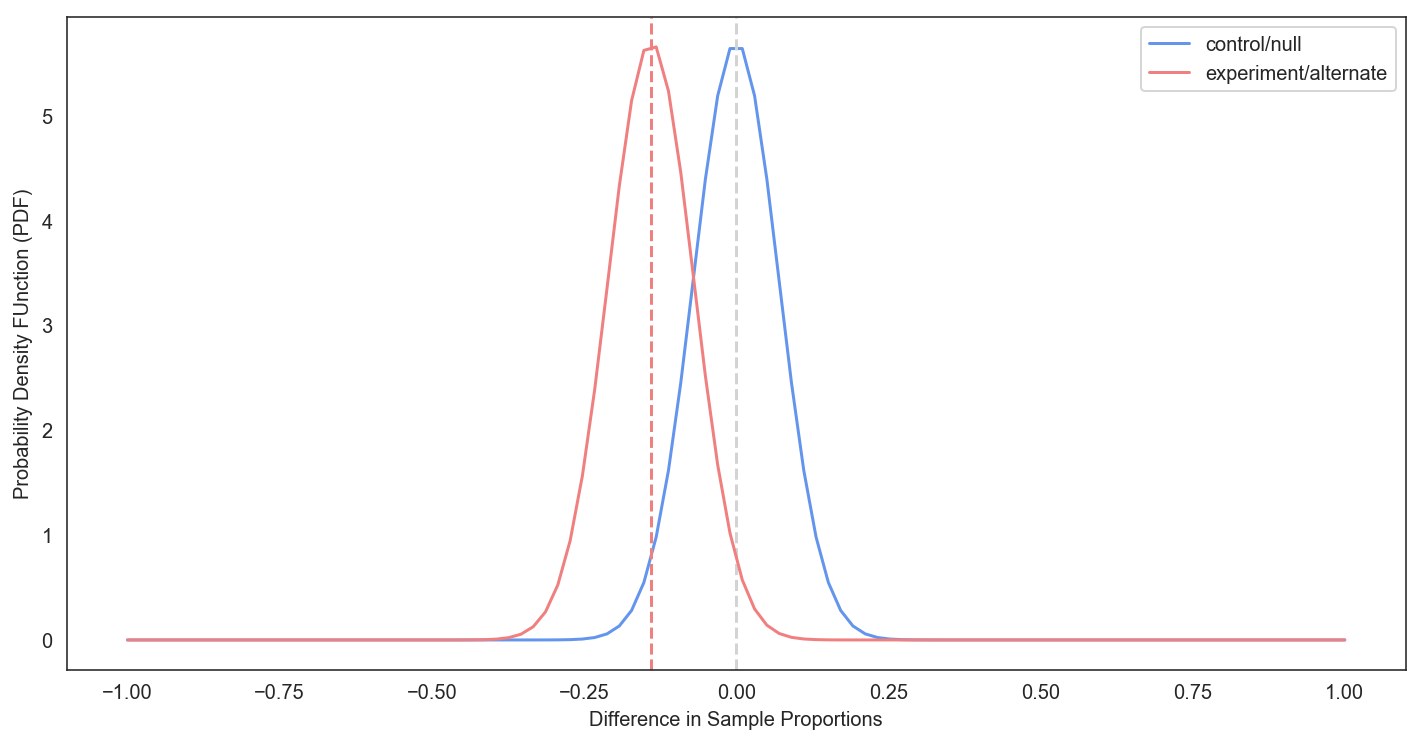

In [369]:
dummydata.plot_sampling_dist_of_difference()

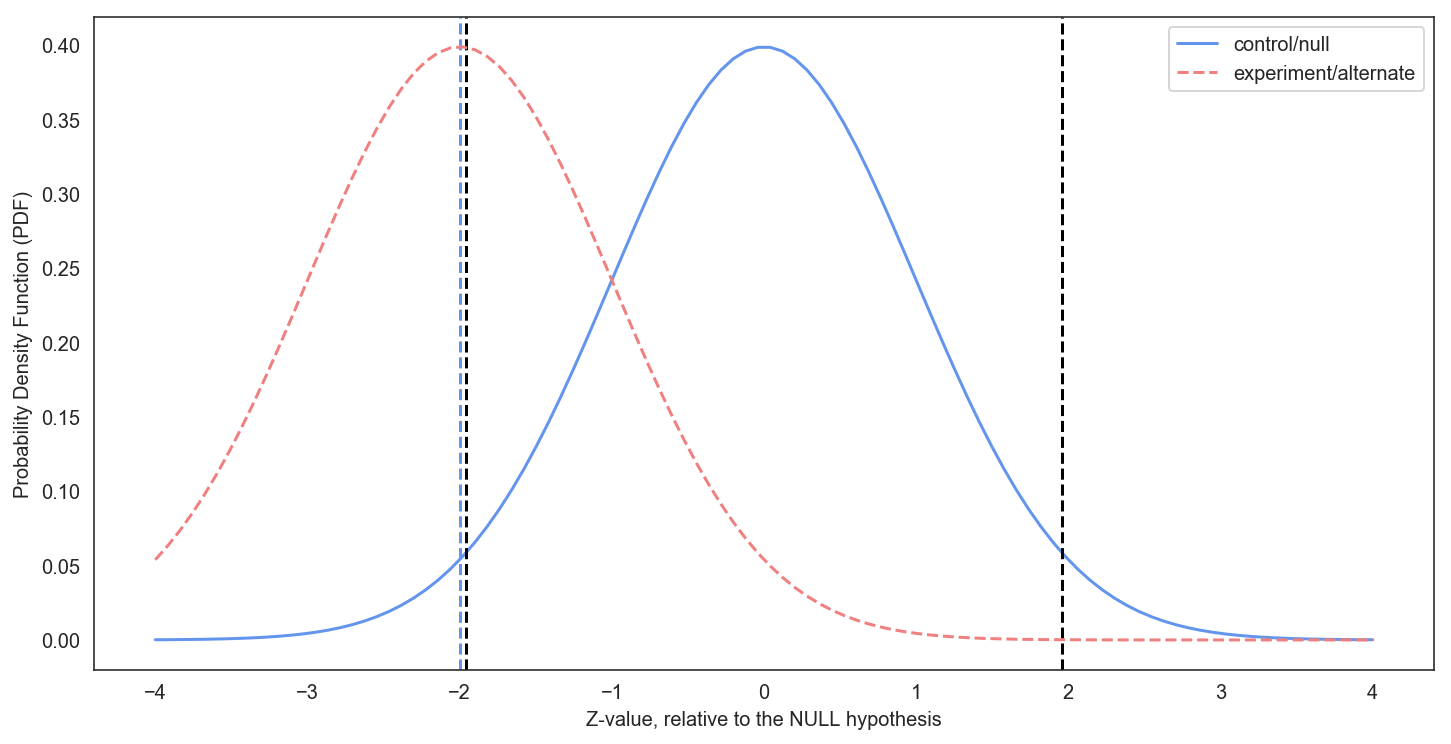

In [370]:
dummydata.plot_sampling_dist_of_difference_standardized(0.05, 'two-tailed')

In [342]:
dummydata.n_A

100

In [120]:
ab_data.head()

,group,converted
0,A,0
1,A,1
2,A,0
3,A,0
4,A,0


In [39]:
# conditions for binomial approximation to the normal distribution

In [40]:
# solve for z statistic, confidence level, p-value manually

In [41]:
# parameters
n_A = 100
n_B = 100
c_A = 50
c_B = 45

p_A = c_A / n_A
p_B = c_B / n_B
p_c = (c_A + c_B) / (n_A + n_B)

Z_score = (
    ((p_A - p_B) - 0) 
    / np.sqrt((p_c * (1 - p_c)) * (1/n_A + 1/n_B))
)  # 0 is the null hypothesis

Z_score

0.7079923254047885

In [42]:
np.sqrt((p_c * (1 - p_c)) * (1/n_A + 1/n_B))

0.07062223445912767

In [346]:
scs.norm(0, 1).ppf(0.975)

1.959963984540054

In [43]:
p_c

0.475

In [44]:
# p-value
p_value = 1 - scs.norm.cdf(Z_score)
p_value

scs.norm.sf(Z_score)

0.23947501171017926

In [ ]:
# check against python implementation

In [33]:
count = np.array([50, 45])
nobs = np.array([100, 100])
value = 0 
z_score, pval = proportions_ztest(count, nobs, value, 
                                  alternative=ve = 'larger',
                                  prop_var = False)

z_score, pval

(0.7079923254047885, 0.23947501171017926)

In [110]:
ab_data

,group,converted
0,A,0
1,A,1
2,A,0
3,A,0
4,A,0
5,A,1
6,A,0
7,A,0
8,A,1
9,A,1


In [ ]:
# check against R implementation

In [6]:
np.sqrt(4)

2.0

In [135]:
### Calculating Sample Size

### ABTest Guide
https://abtestguide.com/abtestsize/

In [2]:
%load_ext rpy2.ipython

R[write to console]: During startup - 
R[write to console]: Warning messages:

R[write to console]: 1: Setting LC_COLLATE failed, using "C" 

R[write to console]: 2: Setting LC_TIME failed, using "C" 

R[write to console]: 3: Setting LC_MESSAGES failed, using "C" 

R[write to console]: 4: Setting LC_MONETARY failed, using "C" 



In [81]:
%%R

calculate_power <- function(p1, p2, power, sig.level) {
    a = power.prop.test(p1 = p1, 
                        p2 = p2, 
                        power, 
                        n = NULL, 
                        sig.level = sig.level,
                        alternative = "two.sided")
    print(a)
    a['n']
}

calculate_power(0.01, 0.012, 0.80, 0.05)


     Two-sample comparison of proportions power calculation 

              n = 42692.8
             p1 = 0.01
             p2 = 0.012
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group

$n
[1] 42692.8



In [ ]:
### EVAN MILLER / STANFORD
# Evan Miller Source Code: 
# https://gist.github.com/mottalrd/7ddfd45d14bc7433dec2#file-gistfile1-txt

In [12]:
from scipy.stats import norm
import math

In [75]:
## Blog post using engineering statistics link
## http://www.alfredo.motta.name/ab-testing-from-scratch/
## https://www.itl.nist.gov/div898/handbook/prc/section2/prc242.htm

def calculate_sample_size(p1, p2, sig_level, power):
    
    delta = abs(p1 - p2)
    
    z_stat_alpha = norm.ppf(1-((1-sig_level)/2))
    z_stat_beta = norm.ppf(power)
    
    sd1 = math.sqrt(p1*(1-p1))
    sd2 = math.sqrt(p2*(1-p2))
    
    n = ((z_stat_alpha * sd1 + z_stat_beta * sd2)/delta) ** 2
    
    return n

print(calculate_sample_size(0.01, 0.012, 0.95, 0.80))

20542.643493459902


In [76]:
## On Evan Miller Website
## and gist: https://gist.github.com/mottalrd/7ddfd45d14bc7433dec2
def calculate_sample_size(p1, p2, sig_level, power):
    
    delta = abs(p1 - p2)
    
    z_stat_alpha = norm.ppf(1-((1-sig_level)/2))
    z_stat_beta = norm.ppf(power)
    
    sd1 = math.sqrt(2 * p1 * (1-p1))
    sd2 = math.sqrt(p1 * (1-p1) + (p1 + delta) * (1 - p1 - delta))
    
    n = ((z_stat_alpha * sd1 + z_stat_beta * sd2)/delta) ** 2
    
    return n

print(calculate_sample_size(0.01, 0.012, 0.95, 0.80))

39985.96074505791


In [98]:
### Stanford Lecture

def calculate_sample_size(p1, p2, sig_level=0.95, 
                          power=0.80, r=1, tails='one'):
    
    delta = abs(p1 - p2)
    
    if tails == 'one':
        z_stat_alpha = norm.ppf(sig_level)
    elif tails == 'two':
        z_stat_alpha = norm.ppf(sig_level + ((1 - sig_level) / 2))
    
    z_stat_beta = norm.ppf(power)
    
    n = ((r+1)/r) * p1 * (1 - p1) * ((z_stat_beta + z_stat_alpha) ** 2) / (delta**2)
    
    return n

print(calculate_sample_size(0.01, 0.012, r=1))

30603.658298497845


In [118]:
calculate_sample_size(0.04, 0.05, sig_level = 0.90, power = 0.80)

3462.0385804128

In [73]:
## https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f
## claims to take from stanford, but looks like pooled variance is wrong. You have to assume the null hypothesis
## crf KA video: https://www.khanacademy.org/math/ap-statistics/two-sample-inference/two-sample-z-test-proportions/v/hypothesis-test-for-difference-in-proportions?modal=1

def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """
    Returns the minimum sample size to set up a split test
    
    Arguments:
        bcr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
        
    Returns:
        min_N: minimum sample size (float)
        
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """

    # find Z_beta from desired power
    Z_beta = norm.ppf(power)

    # find Z_alpha
    Z_alpha = norm.ppf(1-sig_level/2)
    print(Z_alpha)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr+mde) / 2
    print(pooled_prob)

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N

In [63]:
min_sample_size(0.01, 0.002)

1.959963984540054
0.011


42693.98131499187

In [ ]:
## http://powerandsamplesize.com/Calculators/Compare-2-Proportions/2-Sample-Equality
## why is this method using the variance from p(B) if we're supposed to assume null hypothesis is true

In [78]:
# https://select-statistics.co.uk/calculators/sample-size-calculator-two-proportions/

In [79]:
# http://www2.ccrb.cuhk.edu.hk/stat/proportion/Casagrande.htm

In [119]:
# from work notebook

In [121]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, ttest_rel, f_oneway, mannwhitneyu, wilcoxon

import statsmodels.stats.api as sm
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import pandas as pd

In [122]:
class TwoPropZTest():
    
    def __init__(self, control_n, control_conversions, variant_n, variant_conversions):
        self.control_n = control_n
        self.control_conversions = control_conversions
        self.variant_n = variant_n
        self.variant_conversions = variant_conversions
        
        self.control_cr = self.control_conversions/self.control_n
        self.variant_cr = self.variant_conversions/self.variant_n
        
        self.results = {}
        
        
    def z_score(self):
        
        control_se = np.sqrt((self.control_cr*(1-self.control_cr)/self.control_n))
        variant_se = np.sqrt((self.variant_cr*(1-self.variant_cr)/self.variant_n))
        se_diff = np.sqrt(np.power(control_se, 2) + np.power(variant_se, 2))

        z_score = (self.variant_cr-self.control_cr)/se_diff
        
        self.results['z_score'] = z_score
        
        # alternatively
        # z_statistic = stats.zscore(array1-array2) ?
        
        return z_score
    
    def p_value(self):
        
        z_score = self.z_score()
        p_value = 1-stats.norm.cdf(z_score)
        
        self.results['p_value'] = p_value
        
        return p_value
    
    def power(self, alpha, tail='larger'):
        
        # check: http://powerandsamplesize.com/Calculators/Compare-2-Proportions/2-Sample-1-Sided
        # matches R's pwr library
        
        nobs2 = self.variant_n
        ratio = self.variant_n/self.control_n
        
        es = sm.proportion_effectsize(self.variant_cr, self.control_cr) #swapped due to weird sm implementation
        
        power_analysis = sm.NormalIndPower(0)
        power = power_analysis.solve_power(power=None, effect_size=es, 
                                           nobs1=self.control_n, ratio=ratio,
                                           alpha=alpha, alternative=tail)
        
        self.results['power'] = power
        
        return power

In [128]:
def TwoPropZTest_sample_size(ex_control_cr, ex_variant_cr, alpha, power, tail='larger'):
    
    """
    Returns PER GROUP numbers. To get total sample size, multiply by 2
    """
    
    es = sm.proportion_effectsize(ex_variant_cr, ex_control_cr)
    
    test = sm.NormalIndPower(0)
    sample_size = test.solve_power(nobs1=None, ratio=1, effect_size=es, alpha=alpha, power=power, alternative=tail)
    
    return sample_size

In [123]:
class FisherExact():
    
    def __init__(self, control_n, control_conversions, variant_n, variant_conversions):
        
        self.control_n = control_n
        self.control_conversions = control_conversions
        self.variant_n = variant_n
        self.variant_conversions = variant_conversions
        self.results = {}

    def generate_contingency_table(self, control_n, control_conversions, variant_n, variant_conversions):

        control_non = control_n - control_conversions
        variant_non = variant_n - variant_conversions

        cont_array = np.array([[control_conversions, control_non],
                               [variant_conversions, variant_non]])
        
        self.contingency_table = pd.DataFrame(cont_array, 
                                              index=['control', 'variant'],
                                              columns=['convert', 'did not convert'])

        return self.contingency_table
    
    def p_value(self, tail='two-sided'):
        
        cont_table = self.generate_contingency_table(self.control_n, self.control_conversions, 
                                                     self.variant_n, self.variant_conversions)
        
        self.odds_ratio, self.p_value = stats.fisher_exact(cont_table, alternative=tail)
        
        self.results['p value'] = self.p_value
        self.results['odds ratio'] = self.odds_ratio
        
        return self.p_value

In [124]:
ab_test = TwoPropZTest(182, 35, 188, 61)
ab_test.z_score()
ab_test.p_value()
ab_test.power(0.05, 'larger')
ab_test.results

{'z_score': 2.9410157224928595,
 'p_value': 0.0016356896438655122,
 'power': 0.8997528382700732}

In [ ]:
TwoPropZTest_sample_size(0.02, 0.023, 0.05, 0.8, 'larger')

In [125]:
ab_test = TwoPropZTest(182, 35, 188, 61)
ab_test.z_score()
ab_test.p_value()
ab_test.power(0.05, 'two-sided')
ab_test.results

{'z_score': 2.9410157224928595,
 'p_value': 0.0016356896438655122,
 'power': 0.8327366597430156}

In [126]:
ab_test = TwoPropZTest(324, 35, 323, 48)
ab_test.z_score()
ab_test.p_value()
ab_test.power(0.05, 'larger')
ab_test.results

{'z_score': 1.5459382713230716,
 'p_value': 0.06105973827573996,
 'power': 0.46132455828958546}

In [129]:
TwoPropZTest_sample_size(0.1, 0.15, 0.05, 0.8, 'larger')

535.9146420344101

In [130]:
test = FisherExact(324, 35, 323, 48)
test.p_value()
print(test.results)
display(test.contingency_table)

{'p value': 0.1280406654595789, 'odds ratio': 0.6938437139561707}


,convert,did not convert
control,35,289
variant,48,275


In [ ]:
# how to find power for fisher test on python?

In [131]:
stat, p, dof, expected = chi2_contingency(table)

stat, p = ttest_ind(data1, data2)
stat, p = ttest_rel(data1, data2)
stat, p = f_oneway(data1, data2)
stat, p = mannwhitneyu(data1, data2)
stat, p = willcoxon(data1, data2)

NameError: name 'table' is not defined

In [132]:
count = np.array([35, 61])
nobs = np.array([182, 186])
stat, pval = proportions_ztest(count, nobs, 0, alternative='larger')
print(stat)
print(1-pval)

-2.96287653203812
0.001523893967572243


In [133]:
effect_size = 0.3757
ratio = 323/324
power_analysis = zt_ind_solve_power(effect_size = effect_size, nobs1=324, alpha=0.05, 
                                    ratio=ratio, alternative='larger')
power_analysis


NameError: name 'zt_ind_solve_power' is not defined

In [134]:
effect_size = 0.8
alpha = 0.05 # significance level
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size: {0:.2f}'.format(sample_size))

Required sample size: 25.52


### Resources:
- https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html
- Heavily referenced: https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f
- When I tripped over why the normal curves could have y-axis value of greater than 1: https://towardsdatascience.com/pdf-is-not-a-probability-5a4b8a5d9531
